In [14]:
import os
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
import neurokit2 as nk
import scipy.io as sio
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.fft import fft, fftfreq
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, homogeneity_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout, LSTM
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.cluster import KMeans
from sklearn.svm import SVC

# Resumen del Artículo *"Optimal Multi-Stage Arrhythmia Classification Approach"* [8]

Para el análisis de los latidos cardíacos, es fundamental identificar y medir parámetros que reflejen su comportamiento, como la magnitud de los picos, la duración de los intervalos, la distancia entre picos y la variabilidad inherente de los componentes principales de una señal ECG: onda P, onda Q, onda T y el complejo QRS. Sin embargo, estos datos pueden resultar insuficientes para una clasificación precisa de patologías complejas como la fibrilación auricular (AFIB). En estas condiciones, las ondas P suelen ser reemplazadas por ondas asincrónicas de menor amplitud en relación al complejo QRS, dificultando el diagnóstico. Adicionalmente, el uso de transformadas como Wavelet o Fourier para la extracción de características en el dominio de la frecuencia, aunque útiles, puede omitir información valiosa del dominio temporal. Esto resalta la necesidad de metodologías híbridas que integren ambos dominios para mejorar la precisión diagnóstica y adaptarse a la complejidad de patologías como AFIB.

El artículo desarrolla un método optimizado para la extracción de características, diseñado para mejorar el análisis de datos médicos. En este contexto, se evaluaron diversos esquemas de clasificación y selección de características. Se utilizaron dos conjuntos iniciales de características: uno básico con 11 atributos fundamentales y otro más avanzado que contempla hasta 39,830 características derivadas de la señal ECG. Entre las variables consideradas destacan parámetros como la media y la varianza de los intervalos RR, el conteo de estos intervalos, edad, género y métricas asociadas a la derivación II. Este enfoque permite integrar la simplicidad y la complejidad, logrando una caracterización robusta y escalable de los datos médicos.

Se definieron tres conjuntos de características con niveles de complejidad creciente:

-Conjunto 1: se enfoca en variables fisiológicas clave para el estudio del comportamiento del corazón a términos generales, incluye 11 variables esenciales, como la frecuencia auricular y ventricular, latidos por minuto, duración de los complejos QRS, intervalo QT, conteo de QRS y los ejes R y T. Este conjunto posibilita un análisis general del comportamiento cardíaco.

-Conjunto 2:  contempla un mayor número de variables con un grado mayor de complejidad, Comprende 23 variables, la varianza de intervalos RR y características detalladas de altura, anchura y prominencia del complejo QRS, además del conteo de picos y valles en la derivación II.

-Conjunto 6: se presenta como un caso de análisis más complejo, ya que abarca un amplio espectro de características que buscan analizar a fondo la señal ECG y su derivación II, incluyendo características de frecuencias relacionadas con picos no QRS, valles y frecuencias de diferenciación. Este conjunto está diseñado para un análisis detallado y profundo de las señales ECG.

Clasificación Basada en Patrones de Picos y Valles
Los picos y valles se categorizaron en tres subconjuntos: complejo QRS, picos no QRS y valles. Se evaluaron las relaciones entre estos elementos en seis combinaciones diferentes, considerando proporciones de altura, anchura y prominencia frente al tiempo. Este análisis multifacético proporciona una comprensión más integral de las señales ECG, clave para detectar patrones indicativos de patologías cardíacas.

### Discusión
El complejo PQRS es un indicador clave del funcionamiento cardíaco. Sin embargo, en condiciones patológicas donde este desaparece o está distorsionado, el diagnóstico y clasificación de la enfermedad se vuelven más complicados. Para abordar esta problemática, se requieren enfoques que no dependan exclusivamente de la presencia del complejo PQRS.

Para el analisis y clasificacion de señales ECG donde el complejo PQRS ha desaparecido o está presente pero no es suficientemente claro como para analizarlo se han planteado estrategias como:

**Implementar filtros especializados y análisis derivados.**
Algunos sistemas utilizan filtros pasa-altas que eliminan el ruido de baja frecuencia y la línea base, posteriormente se aplican 2 filtros pasa-bajas que mejoran la calidad de la señal. Para finalmente derivar la señal original con el fin de magnificar los cambios de amplitud, posibilitando así la identificación de características como picos QRS incluso si están alterados. Esto acompañado de una técnica de rectificación y umbralización para aislar la clase de la seña [12].

**Técnicas de discriminacion de umbrales.**
Mediante la aplicación de algoritmos Pan-Tompkins, modificados es posible detectar picos específicos como los picos R, aunque otras ondas sean poco claras. Este tipo de técnicas se fundamentan en la interpretación de parámetros de amplitud y tiempo para descartar datos atípicos [12].

**Enfoques de modelado alternativo.**
En casos donde los complejos PQRS están alterados o son inexistentes, se consideran métodos para analizar derivados temporales o espectrales de la señal, con el fin de extraer información de patrones no convencionales y así caracterizar patologías específicas [13].


# Introducción

El análisis de señales electrocardiográficas (ECG) es una herramienta fundamental en el diagnóstico de enfermedades cardiovasculares, ya que permite evaluar la actividad eléctrica del corazón y detectar anomalías en su funcionamiento. Condiciones como la fibrilación auricular (AFIB) y la bradicardia sinusal (SB) representan retos significativos para los sistemas de diagnóstico debido a la similitud en sus patrones eléctricos y a la complejidad inherente de las señales ECG. Para mejorar la precisión en la clasificación de estas patologías, es necesario desarrollar métodos avanzados que integren técnicas de extracción de características robustas y algoritmos predictivos de alto rendimiento.

En este informe se presenta un enfoque metodológico para el análisis de señales ECG centrado en la derivación II, seleccionada por su relevancia clínica en la identificación de alteraciones cardíacas. Las señales se procesaron utilizando técnicas de normalización y eliminación de offset, y se extrajeron características tanto en el dominio temporal como espectral mediante la biblioteca Neurokit y métodos complementarios. Estos parámetros abarcaron desde medidas básicas, como frecuencias cardíacas y amplitudes de picos, hasta métricas más complejas, como la frecuencia de máxima potencia y la variabilidad de los intervalos RR.

Con el propósito de evaluar la capacidad de clasificación de estas características, se implementaron múltiples modelos de aprendizaje supervisado y no supervisado, incluyendo redes neuronales de tipo Perceptrón Multicapa (MLP), redes convolucionales (CNN), redes recurrentes (RNN), algoritmos de agrupamiento no supervisado como K-Means y máquinas de soporte vectorial (SVM). Cada modelo fue evaluado en términos de su precisión, sensibilidad y especificidad, ofreciendo un análisis detallado de su rendimiento en la clasificación de AFIB y SB.

El presente informe busca no solo destacar la efectividad de los métodos implementados, sino también identificar las fortalezas y limitaciones de cada enfoque, aportando así información relevante para futuros desarrollos en el análisis automático de señales ECG y su aplicación en contextos clínicos.


# Metodología 

El presente trabajo se basa en el análisis y clasificación de señales ECG provenientes de pacientes con dos condiciones específicas: fibrilación auricular (AFIB) y bradicardia sinusal (SB). Los datos utilizados corresponden a las señales de ECG registradas en la derivación II, previamente filtradas como parte del proyecto 2. Estas señales fueron agrupadas en diccionarios independientes para cada condición (AFIB y SB). Para garantizar la integridad de los análisis, se aplicaron dos transformaciones clave a las señales:

- Se realizó una compresión uniforme para estandarizar la escala de las señales.

- Se aplicó un detrend para eliminar desplazamientos no deseados en las señales, asegurando así que las variaciones relevantes fueran atribuibles únicamente a la actividad cardíaca.


La extracción de características fue una etapa crucial para representar adecuadamente la información de las señales ECG. Para ello se utilizó la biblioteca Neurokit [14], que permitió extraer características fundamentales como frecuencias cardíacas, variabilidad de los intervalos RR, parámetros de amplitud y duración del complejo QRS, entre otros. Se complementó con la identificación de la frecuencia de máxima potencia de cada señal, un parámetro calculado a partir de la densidad espectral de potencia (PSD) también calculado en anteriores proyectos. Todas estas características fueron organizadas en un dataframe, consolidando un conjunto robusto de datos representativos de las señales. Este enfoque permitió integrar información en el dominio temporal y espectral, clave para mejorar la precisión de los modelos predictivos.

El dataframe fue sometido a un tratamiento exhaustivo para asegurar su compatibilidad con los modelos predictivos:

- Para evitar inconsistencias en los análisis y resultados.

- Por ejemplo, identificadores o información redundante que no contribuía a la predicción.

- Para escalar las características y evitar desbalances debido a magnitudes heterogéneas.

Luego se implementaron y evaluaron cinco enfoques predictivos principales:

-Redes Neuronales Perceptrón Multicapa (MLP): Se definieron tres configuraciones distintas para evaluar el impacto de diferentes arquitecturas y ajustes de hiperparámetros en la clasificación de AFIB y SB.

-Red Neuronal Convolucional (CNN): Diseñada para aprovechar patrones espaciales en las señales, especialmente útiles para identificar características locales.

-Red Neuronal Recurrente (RNN): Configurada para modelar las dependencias temporales en las señales ECG.

-K-Means: Implementado como un algoritmo de agrupamiento no supervisado, evaluando su capacidad para separar de manera autónoma las clases AFIB y SB.

-Máquinas de Soporte Vectorial (SVM): Configuradas con un kernel radial (rbf), y parámetros ajustados para maximizar la generalización del modelo.

Cada modelo fue evaluado utilizando métricas estándar de clasificación, como precisión, sensibilidad (recall), puntuación F1 y una matriz de confusión. Estas métricas permitieron analizar el desempeño en términos de su capacidad para distinguir entre las dos condiciones (AFIB y SB).

# Extracción de los datos del proyecto 2

Se seleccionaron los datos utilizados en el Proyecto 2, los cuales ya estaban previamente filtrados. Esto se debe a que los métodos empleados para el procesamiento de las señales en dicho proyecto generaron señales en condiciones óptimas para un análisis exhaustivo y de alto nivel de detalle. Este procesamiento permitió capturar con mayor precisión las características específicas de señales asociadas a enfermedades como la Fibrilación Auricular (AFIB) y la Bradicardia Sinusal (SB). Es importante destacar que, al comparar los resultados obtenidos en el Proyecto 3 con los del Proyecto 2, se evidenció un sesgo significativo en la filtración de señales del Proyecto 3. Este sesgo impactó negativamente en las condiciones de las señales, que no cumplían con los mismos estándares que las del Proyecto 2. Este problema quedó reflejado particularmente en la extracción de la fMP (frecuencia de máxima potencia), donde los valores de las señales del Proyecto 3 no solo diferían de los obtenidos en el Proyecto 2, sino que también mostraban un incremento tanto en magnitud como en variabilidad.

Como consecuencia, las señales del Proyecto 3 fueron descartadas debido a su inconsistencia y falta de confiabilidad. Por ello, se decidió utilizar exclusivamente las señales filtradas del Proyecto 2 para garantizar la validez y precisión del análisis.

In [16]:
def extract_filenames_with_rhythm(excel_path, AFIB_rhythms=['AFIB'], SB_rhythms=['SB']):
    # Leer el archivo Excel
    df = pd.read_excel(excel_path)
    
    # Filtrar por los ritmos deseados
    AFIB_df = df[df['Rhythm'].isin(AFIB_rhythms)]
    SB_df = df[df['Rhythm'].isin(SB_rhythms)]
    
    # Extraer los valores de la columna 'FileName'
    AFIB = AFIB_df['FileName'].values.tolist()
    SB = SB_df['FileName'].values.tolist()
    
    return AFIB, SB

def read_ecg_files(AFIB, SB, folder_path):
    AFIB_data = {}
    for file_name in AFIB:
        file_path = os.path.join(folder_path, f"{file_name}.csv")
        
        # Verificar si el archivo existe
        if os.path.exists(file_path):
            # Leer el archivo .csv
            df = pd.read_csv(file_path, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            
            # Guardar los datos de la columna 'II'
            AFIB_data[file_name] = df['II'].values
        else:
            print(f"Archivo {file_path} no encontrado.")
            
    SB_data = {}
    for file_name in SB:
        file_path = os.path.join(folder_path, f"{file_name}.csv")
        
        # Verificar si el archivo existe
        if os.path.exists(file_path):
            # Leer el archivo .csv
            df = pd.read_csv(file_path, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
            
            # Guardar los datos de la columna 'II'
            SB_data[file_name] = df['II'].values
        else:
            print(f"Archivo {file_path} no encontrado.")
    
    return AFIB_data, SB_data

# Ruta al archivo Excel y a la carpeta de archivos .csv

excel_path = r'C:\Users\santi\OneDrive\Escritorio\Bioseñales\Proyecto 2\Diagnostics.xlsx'
csv_folder_path = r'C:\Users\santi\OneDrive\Escritorio\Bioseñales\Proyecto 2\ECGDataDenoised'

# Extraer los nombres de archivos que nos interesan
AFIB, SB = extract_filenames_with_rhythm(excel_path)

# Leer los archivos .csv correspondientes y extraer la columna 'II'
AFIB_new, SB_new = read_ecg_files(AFIB, SB, csv_folder_path)

# `ecg_values` es un diccionario donde cada clave es el nombre del archivo y el valor son los datos de la columna 'II'.

# Creacion del Dataframe calculando las diferentes características de la librería Neurokit2 (incluyendo el cálculo de la fMP)

El análisis de señales ECG (electrocardiograma) es fundamental para la identificación y diferenciación de arritmias cardíacas, como la Fibrilación Auricular (AFIB) y la Bradicardia Sinusal (SB). Estas patologías presentan patrones distintivos en los registros ECG, y las características seleccionadas en este análisis desempeñan un papel crucial para su diagnóstico preciso.

## Características:
**1. Promedio de la frecuencia cardíaca (Heart_Rate_Mean):** 
Representa la frecuencia promedio a la que el corazón late durante el periodo analizado. En sujetos con AFIB, esta métrica tiende a ser irregular debido a la naturaleza caótica de los impulsos eléctricos en las aurículas. En contraste, en la SB, el ritmo cardíaco es consistentemente lento. se busca diferenciar entre la irregularidad típica de la AFIB y la lentitud constante característica de la SB.


**2. Desviación estándar de la frecuencia cardíaca (HRV_SDNN):**
Es una medida de la variabilidad de la frecuencia cardíaca (HRV), que refleja la actividad del sistema nervioso autónomo. En la AFIB, esta métrica puede mostrar una alta variabilidad debido a la naturaleza impredecible de los intervalos entre latidos. En la SB, la variabilidad es más limitada, dado que los latidos son más uniformes. Se busca evaluar los niveles de variabilidad y usarlos como un marcador para distinguir la irregularidad extrema de la AFIB frente a la estabilidad relativa de la SB.


**3. Promedio de los intervalos RR (RR_Interval_Mean):**
Los intervalos RR representan el tiempo entre latidos sucesivos. En la AFIB, estos intervalos son altamente variables, mientras que en la SB, suelen ser consistentemente largos debido a la bradicardia. Se busca identificar la irregularidad en los intervalos RR como un indicador distintivo de la AFIB y diferenciarlos de los intervalos prolongados pero regulares de la SB.


**4. Promedio de la amplitud de la onda R (R_Amplitude_Mean):**
La amplitud de la onda R refleja la fuerza del impulso eléctrico generado durante la despolarización ventricular. Cambios en esta característica pueden estar relacionados con la calidad del registro y la salud del miocardio, que a menudo está comprometido en estas patologías. Se busca identificar diferencias sutiles en la amplitud de la onda R como un posible indicador secundario en el diagnóstico diferencial.


**5. Raíz cuadrada de la media de las diferencias al cuadrado de los intervalos RR sucesivos (HRV_RMSSD):**
Esta métrica es un indicador sensible de la actividad parasimpática en la variabilidad de la frecuencia cardíaca. En la AFIB, RMSSD puede ser elevado debido a las grandes fluctuaciones en los intervalos RR. En la SB, las fluctuaciones son menos pronunciadas. Se busca medir las fluctuaciones rápidas en los intervalos RR y utilizarlas como un criterio para evaluar la irregularidad de la AFIB en comparación con la SB.


**6. Promedio de la duración de la onda P (P_Wave_Duration_Mean):**
La onda P corresponde a la actividad auricular. En la AFIB, las ondas P pueden ser inexistentes o deformadas debido a la actividad auricular desorganizada. En la SB, las ondas P son más claras y están presentes, pero pueden mostrar cambios en su duración. Se busca diferenciar entre la duración promedio de la onda P en la AFIB y la onda P en la SB.

In [3]:
def compression(c_tk, x_min, x_max):
    s_tk = (c_tk - x_min) / (x_max - x_min)
    return s_tk

def extract_fmp(signal, N=500, sample_rate=500):
    signal_detrended = detrend(signal)
    
    # 2. Aplicar compresión
    x_min = np.min(signal_detrended)
    x_max = np.max(signal_detrended)
    compressed_signal = compression(signal_detrended, x_min, x_max)
    
    # 3. Aplicar detrend nuevamente sobre la señal comprimida
    processed_signal = detrend(compressed_signal)
    X_f = fft(processed_signal, N)
    X_f = X_f[:N//2]
    freqs = fftfreq(N, 1/sample_rate)[:N//2]
    power_spectrum = np.abs(X_f) ** 2
    fMP = freqs[np.argmax(power_spectrum)]
    return fMP

def extract_ecg_features(signal_ekg, fs):
    # Detectar los picos R
    signals, rpeaks = nk.ecg_peaks(signal_ekg, sampling_rate=fs, correct_artifacts=False)

    # Verificar si hay picos detectados
    if "ECG_R_Peaks" not in rpeaks or len(rpeaks["ECG_R_Peaks"]) == 0:
        return {
            "Heart_Rate_Mean": np.nan,
            "HRV_SDNN": np.nan,
            "RR_Interval_Mean": np.nan,
            "R_Amplitude_Mean": np.nan,
            "HRV_RMSSD": np.nan,
            "P_Wave_Duration_Mean": np.nan
        }

    # 1. Frecuencia cardíaca promedio (HR)
    heart_rate = nk.ecg_rate(rpeaks['ECG_R_Peaks'], sampling_rate=fs)
    heart_rate_mean = heart_rate.mean()

    # 2. Variabilidad de la frecuencia cardíaca (HRV - SDNN)
    hrv_metrics = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
    hrv_sdnn = hrv_metrics["HRV_SDNN"][0]

    # 3. Duración promedio de los intervalos RR
    rr_intervals = np.diff(rpeaks['ECG_R_Peaks']) / fs  # Convertir a segundos
    rr_interval_mean = rr_intervals.mean()

    # 4. Promedio de la amplitud de los picos R
    if len(rpeaks['ECG_R_Peaks']) > 0:
        r_amplitude_mean = signal_ekg[rpeaks['ECG_R_Peaks']].mean()
    else:
        r_amplitude_mean = np.nan

    # 5. HRV RMSSD
    hrv_rmssd = hrv_metrics["HRV_RMSSD"][0]

    # 6. Duración promedio de las ondas P
    try:
        delineation, waves = nk.ecg_delineate(signal_ekg, rpeaks, sampling_rate=fs, method="dwt", show=False)
        if "ECG_P_Onsets" in waves and "ECG_P_Offsets" in waves:
            # Duraciones de las ondas P
            p_durations = np.array(waves["ECG_P_Offsets"]) - np.array(waves["ECG_P_Onsets"])
            p_wave_duration_mean = (p_durations.mean() / fs) if len(p_durations) > 0 else np.nan  # En segundos
        else:
            p_wave_duration_mean = np.nan
    except ValueError:
        # Si ocurre un error en el delineado, retornar NaN
        p_wave_duration_mean = np.nan

    # Retornar las características como un diccionario
    return {
        "Heart_Rate_Mean": heart_rate_mean,
        "HRV_SDNN": hrv_sdnn,
        "RR_Interval_Mean": rr_interval_mean,
        "R_Amplitude_Mean": r_amplitude_mean,
        "HRV_RMSSD": hrv_rmssd,
        "P_Wave_Duration_Mean": p_wave_duration_mean
    }

def process_ecg_signals(AFIB_new, SB_new, fs):
    results = []

    # Procesar señales AFIB
    for AFIB_name, signal in AFIB_new.items():
        neurokit_features = extract_ecg_features(signal, fs)
        fmp = extract_fmp(signal)  # Calcular fMP
        results.append({
            'Registro': AFIB_name,
            'Estado': 'AFIB',
            'fMP': fmp,
            **neurokit_features
        })

    # Procesar señales SB
    for SB_name, signal in SB_new.items():
        neurokit_features = extract_ecg_features(signal, fs)
        fmp = extract_fmp(signal)  # Calcular fMP
        results.append({
            'Registro': SB_name,
            'Estado': 'SB',
            'fMP': fmp,
            **neurokit_features
        })

    # Convertir a DataFrame
    df_results = pd.DataFrame(results)
    return df_results


# Parámetros
fs = 500  # Frecuencia de muestreo

# Procesar señales y generar DataFrame
df_results = process_ecg_signals(AFIB_new, SB_new, fs)

# Mostrar el DataFrame resultante
print(df_results)

C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\santi\AppData\Roaming\Python\Python3

                        Registro Estado   fMP  Heart_Rate_Mean    HRV_SDNN  \
0     MUSE_20180113_171327_27000   AFIB  13.0       118.260506   51.090718   
1     MUSE_20180114_075026_69000   AFIB   5.0       100.169452  135.473491   
2     MUSE_20180113_133901_16000   AFIB   3.0        74.166620  148.141701   
3     MUSE_20180116_123940_90000   AFIB   3.0        81.717337  172.858323   
4     MUSE_20180114_075003_61000   AFIB   0.0        87.290724  160.333786   
...                          ...    ...   ...              ...         ...   
5664  MUSE_20180114_070348_17000     SB   8.0        55.215809   34.138374   
5665  MUSE_20180114_134724_10000     SB   4.0        56.070866   30.330324   
5666  MUSE_20180113_122544_20000     SB   4.0        55.495642   58.908525   
5667  MUSE_20180114_074720_85000     SB  11.0        56.955826   20.352255   
5668  MUSE_20180116_133908_01000     SB   1.0        56.390756   18.343936   

      RR_Interval_Mean  R_Amplitude_Mean   HRV_RMSSD  P_Wave_Du

# Análisis de los resultados

**fMP (Frecuencia de Máxima Potencia):**
Los valores de fMP en la categoría AFIB varían entre 0 y 13, con una tendencia a estar en el rango bajo (generalmente debajo de 10). Esto sugiere que la AFIB, que es una arritmia caracterizada por una actividad auricular desorganizada, puede estar asociada con frecuencias de máxima potencia más bajas debido a la irregularidad en los latidos y las fluctuaciones rápidas en la señal ECG. Por otro lado, los valores de fMP en la categoría SB son más consistentes y también más bajos que en AFIB, con un rango de 1 a 11. Los valores más bajos pueden sugerir un comportamiento regular y predecible del corazón en SB, dado que la bradicardia sinusal es un ritmo cardíaco lento pero regular. Aunque la diferencia no es abrumadora, las señales de AFIB parecen tener más variabilidad en la frecuencia de máxima potencia en comparación con la SB, lo que refleja la irregularidad inherente a la fibrilación auricular, aspecto confirmado por los resultados obtenidos en el proyecto 2.

**Heart_Rate_Mean (Promedio de la frecuencia cardíaca):**
En la categoría AFIB, el Heart_Rate_Mean varía considerablemente, con valores que oscilan entre 74 y 118 latidos por minuto (lpm). Esto es consistente con la naturaleza irregular de la fibrilación auricular, en la que los latidos cardíacos pueden ser tanto rápidos como desorganizados, resultando en un promedio relativamente elevado. Mientras que en SB, el promedio de la frecuencia cardíaca está en un rango más bajo, entre 55 y 56 lpm. Esto se debe a que la bradicardia sinusal se caracteriza por un ritmo cardíaco lento y regular, que es significativamente más bajo que los valores observados en AFIB. El Heart_Rate_Mean en AFIB es considerablemente más alto que en SB, lo que refleja la naturaleza rápida y desorganizada de la fibrilación auricular frente al ritmo más lento y constante de la bradicardia sinusal.

**HRV_SDNN (Desviación estándar de los intervalos RR):**
Los valores de HRV_SDNN en AFIB varían significativamente, con valores que van desde 51.09 hasta 172.86. La alta variabilidad de los intervalos RR en AFIB es indicativa de la irregularidad de los latidos debido a la conducción caótica de los impulsos eléctricos a través de las aurículas.En SB, los valores de HRV_SDNN son mucho más bajos, con un rango entre 18.34 y 58.91. La baja variabilidad en SB refleja la regularidad del ritmo cardíaco lento, sin fluctuaciones impredecibles en la duración de los intervalos. AFIB presenta una variabilidad significativamente mayor en los intervalos RR, lo que se refleja en una HRV_SDNN más alta en comparación con SB, que tiene una variabilidad baja debido a su ritmo constante.

**RR_Interval_Mean (Promedio de los intervalos RR):**
En AFIB, los valores de RR_Interval_Mean son más pequeños y varían entre 0.51 y 0.83 segundos. La irregularidad en los latidos cardíacos da lugar a un intervalo RR promedio más variable, aunque sigue siendo relativamente corto debido a la frecuencia elevada característica de la fibrilación. Para SB, los valores de RR_Interval_Mean son significativamente mayores, con un rango entre 1.05 y 1.09 segundos, lo que indica un intervalo regular y largo, típico de la bradicardia sinusal. Los intervalos RR promedio en AFIB son más cortos y variables reflejando la variabilidad e irregularidad propia en la actividad cardíaca de la fibrilación, mientras que en SB son más largos y estables, lo que refleja el ritmo cardíaco más lento y constante de la bradicardia.

**R_Amplitude_Mean (Amplitud promedio de la onda R):**
Los valores de R_Amplitude_Mean en AFIB varían significativamente entre 288.93 y 711.42, lo que sugiere una gran variabilidad en la amplitud de la onda R. Esta variabilidad podría estar relacionada con la irregularidad de los latidos y la desorganización de la actividad cardíaca en AFIB. Por otra parte para SB, la amplitud de la onda R es más consistente, con valores que oscilan entre 494.68 y 1324.98. Los valores son más altos en comparación con AFIB, lo que puede ser una indicación de que los latidos regulares y más lentos en SB producen una onda R más uniforme. La amplitud de la onda R es más variable en AFIB debido a la irregularidad de los latidos, mientras que en SB es más estable debido al ritmo regular.

**HRV_RMSSD (Raíz cuadrada de la media de las diferencias al cuadrado de los intervalos RR sucesivos):**
Los valores de HRV_RMSSD en AFIB son más altos, con un rango entre 27.90 y 274.34, reflejando la alta variabilidad de los intervalos RR en la fibrilación auricular. Mientras que en SB, los valores de HRV_RMSSD son más bajos, con un rango entre 27.90 y 82.98, lo que indica una menor variabilidad en los intervalos RR debido al ritmo más regular de la bradicardia. La HRV_RMSSD es considerablemente mayor en AFIB debido a la irregularidad de los latidos, mientras que es más baja en SB, que presenta un ritmo más estable.

**P_Wave_Duration_Mean (Duración promedio de la onda P):**
En AFIB, los valores de P_Wave_Duration_Mean son muy bajos o incluso cercanos a cero, lo que indica que las ondas P están ausentes o muy distorsionadas debido a la desorganización de la actividad auricular en la fibrilación. En SB, la duración de la onda P es más consistente, con valores que varían entre 0.04 y 0.12 segundos, lo que refleja una conducción auricular más regular y organizada, típica de la bradicardia sinusal. La onda P en AFIB es casi inexistente o muy distorsionada debido a la desorganización auricular, mientras que en SB es regular y de duración constante.

In [4]:
df_results.to_csv('Dataframe.csv', index=False)

# Se seleccionan algunas señales para el tutorial y ademas para mostrar gráficamente las características seleccionadas de la librería Neurokit2

In [5]:
AFIB_reducido = dict(list(AFIB_new.items())[:2])
SB_reducido = dict(list(SB_new.items())[:2])

print("Diccionario AFIB reducido:", AFIB_reducido)
print("Diccionario SB reducido:", SB_reducido)

Diccionario AFIB reducido: {'MUSE_20180113_171327_27000': array([381.94 , 381.92 , 380.63 , ...,  13.736,  21.127,  31.464]), 'MUSE_20180114_075026_69000': array([-26.846 ,  -4.778 ,  14.99  , ..., -29.008 ,  -9.6002,  12.339 ])}
Diccionario SB reducido: {'MUSE_20180112_073319_29000': array([27.367, 21.567, 16.269, ..., 12.501, 11.9  , 11.158]), 'MUSE_20180113_121940_44000': array([118.49 , 117.41 , 115.43 , ...,  11.557,  10.687,  10.046])}


In [17]:
csv = r'C:\Users\santi\OneDrive\Escritorio\Bioseñales\Proyecto 2\ECGDataDenoised\MUSE_20180113_171327_27000.csv'
df = pd.read_csv(csv, delimiter=',', names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
ecg = df['II'].values

C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\neurokit2\ecg\ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


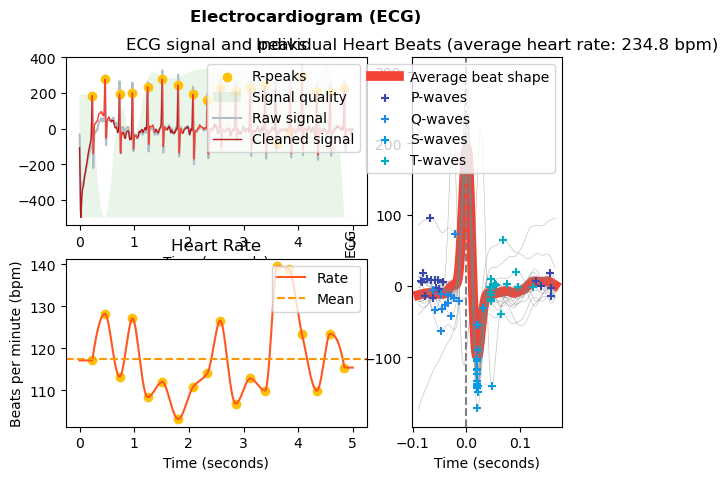

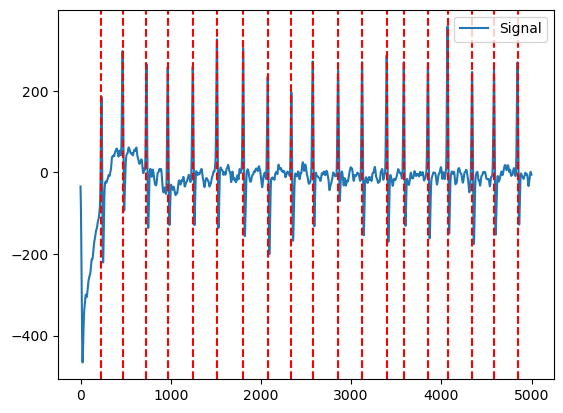

In [18]:
# Se utiliza un método de limpieza específico ("neurokit") y una frecuencia de muestreo de 250 Hz.
ecg_signal_cleaned = nk.ecg_clean(ecg,sampling_rate=500,method='neurokit')

# Detección de los picos R en la señal limpia
# Esta función devuelve información sobre los picos R detectados.
_,rpeaks = nk.ecg_peaks(ecg_signal_cleaned,sampling_rate=500)

# Procesamiento de la señal ECG (delimitación y extracción de características)
ecg_signals, ecg_info = nk.ecg_process(ecg_signal_cleaned, sampling_rate=500)

# Visualización de la señal limpia y las principales características
nk.ecg_plot(ecg_signals)

# Visualización de eventos específicos, como los picos R, sobre la señal limpia
# Este gráfico superpone los eventos detectados sobre la señal procesada.
plot = nk.events_plot(rpeaks['ECG_R_Peaks'],ecg_signal_cleaned)

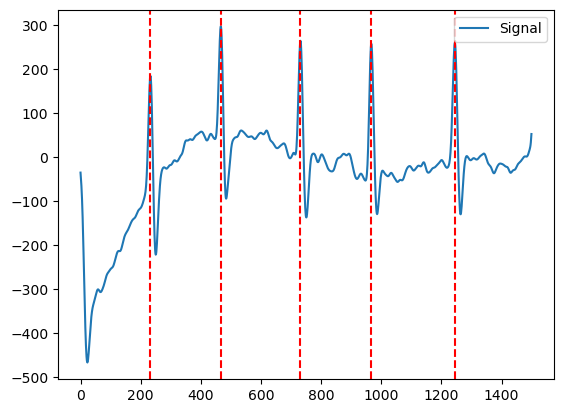

In [24]:
plot = nk.events_plot(rpeaks['ECG_R_Peaks'][:5], ecg_signal_cleaned[:1500])

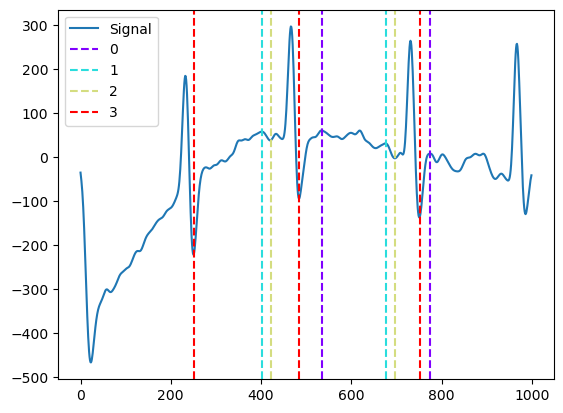

In [21]:
_,waves_peak = nk.ecg_delineate(ecg_signal_cleaned, rpeaks, sampling_rate=500,method="peak")

# Se utiliza la función `events_plot` para visualizar las ubicaciones de los picos P, Q, S, T sobre la señal de ECG.
# Se extraen y se muestran las primeras 3 localizaciones de cada onda (P, Q, S, T) utilizando slices.
# Estas ubicaciones se visualizan en el primer segmento de la señal (las primeras 3000 muestras).
plot= nk.events_plot([waves_peak['ECG_T_Peaks'][:3],         #Primeros 3 picos T
                      waves_peak['ECG_P_Peaks'][:3],         #Primeros 3 picos P
                      waves_peak['ECG_Q_Peaks'][:3],         #Primeros 3 picos Q
                      waves_peak['ECG_S_Peaks'][:3]]         #Primeros 3 picos S
                     , ecg_signal_cleaned[:1000])            #Primeros 300 puntos de la señal ECG limpia

                     Registro Estado  Heart_Rate_Mean    HRV_SDNN  \
0  MUSE_20180113_171327_27000   AFIB       118.260506   51.090718   
1  MUSE_20180114_075026_69000   AFIB       100.169452  135.473491   
2  MUSE_20180112_073319_29000     SB        51.721042   27.945525   
3  MUSE_20180113_121940_44000     SB        53.319737   17.492856   

   RR_Interval_Mean  R_Amplitude_Mean   HRV_RMSSD  P_Wave_Duration_Mean  
0          0.512556        346.471579   81.263551              0.040000  
1          0.626933        494.681250  176.972960              0.045375  
2          1.160571        977.323750   47.588514              0.075000  
3          1.125500        925.055556   25.511902              0.071556  


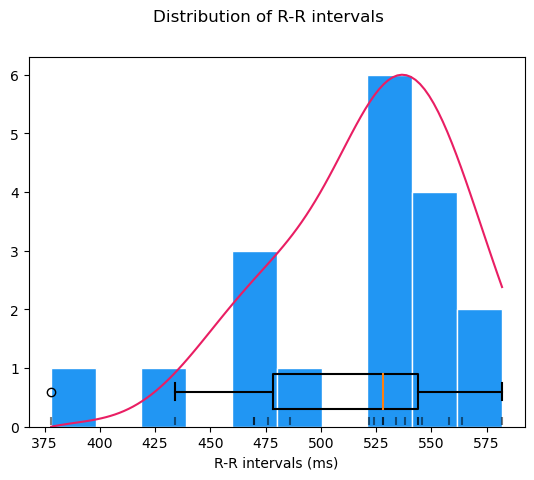

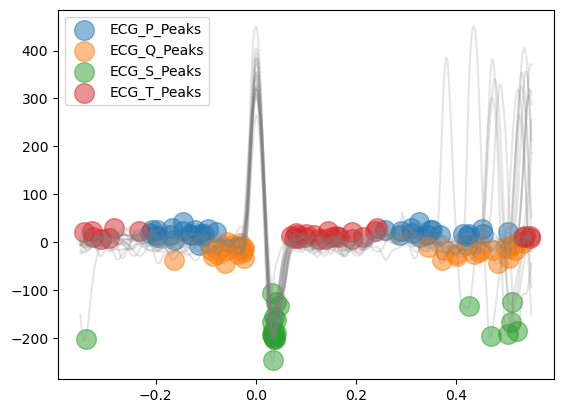

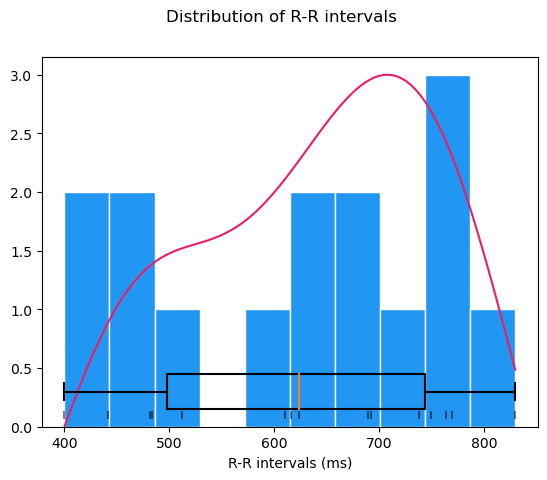

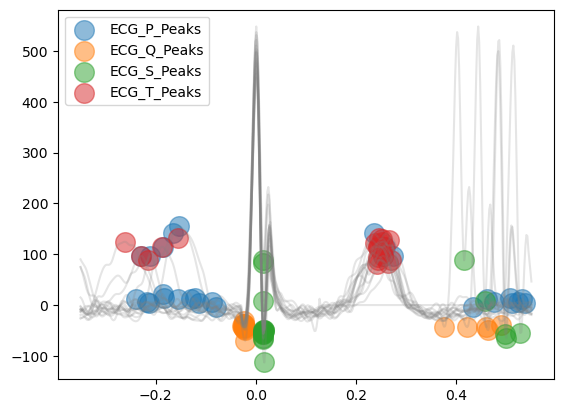

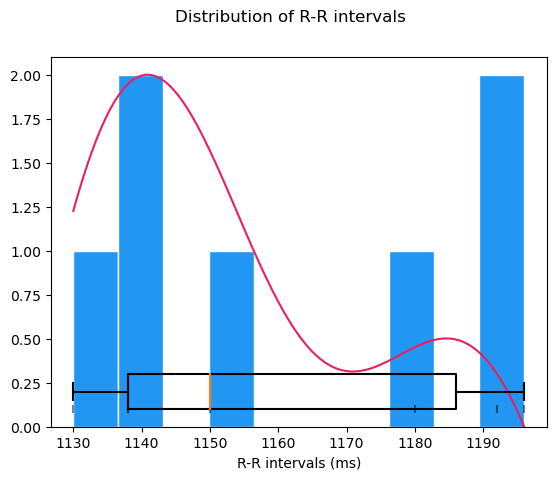

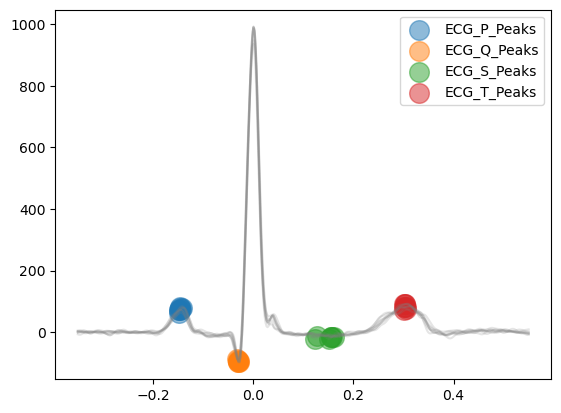

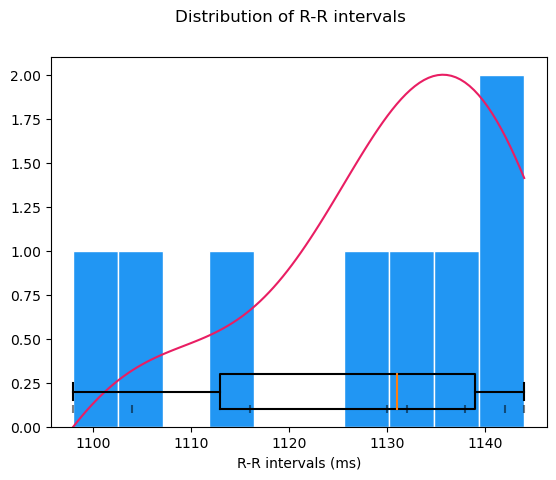

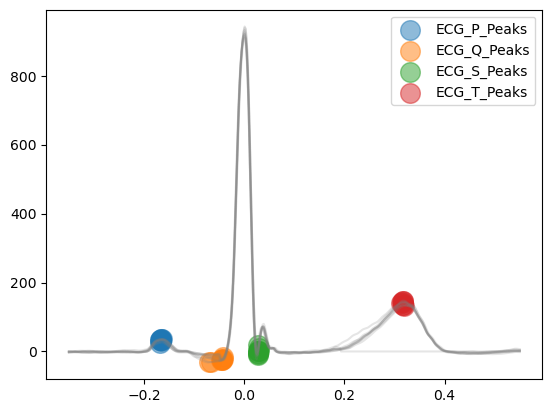

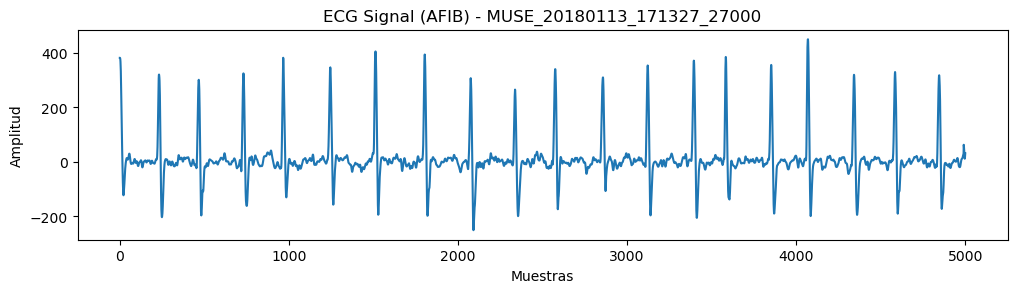

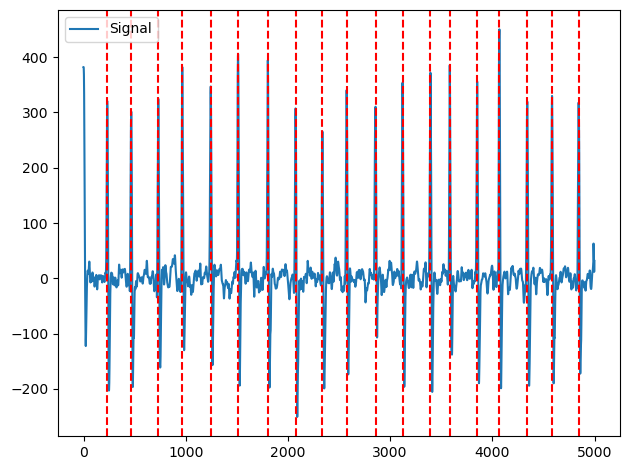

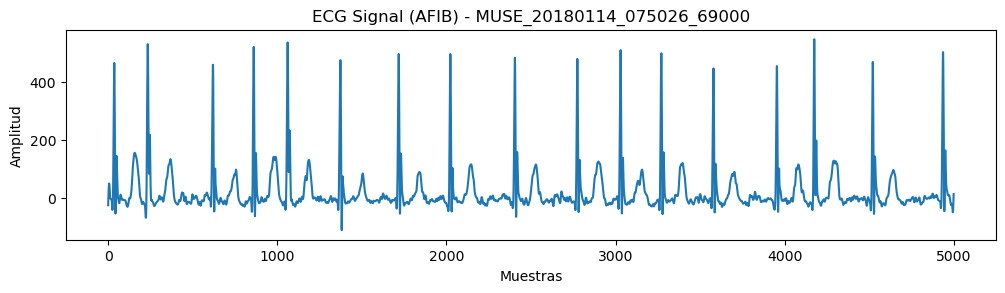

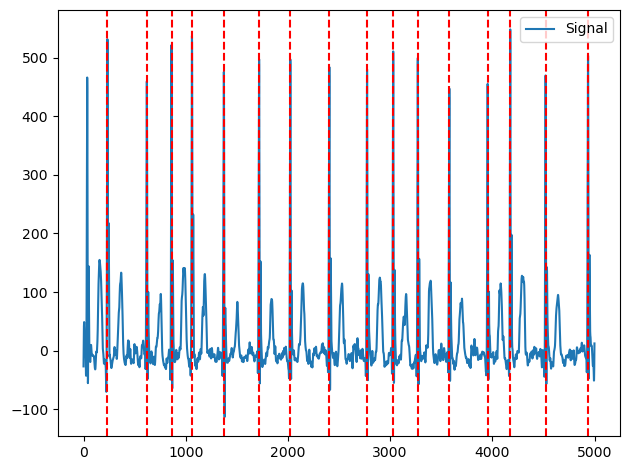

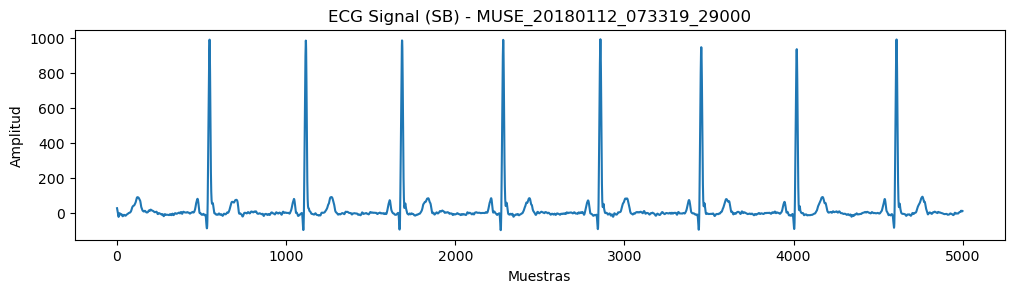

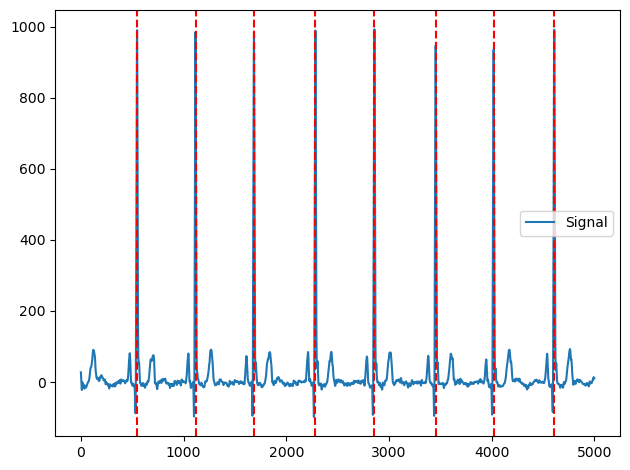

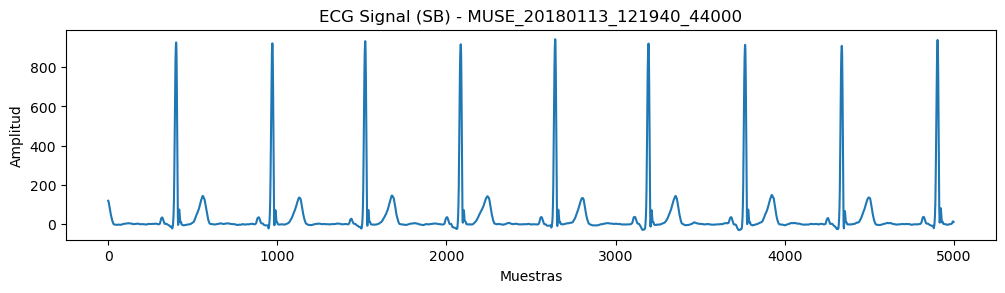

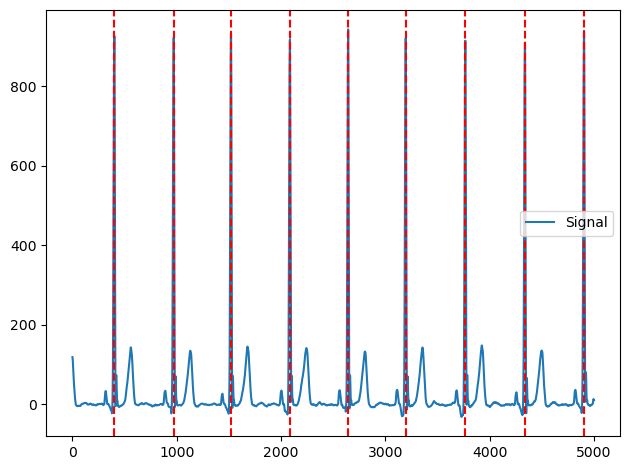

In [6]:
def extract_ecg_features(signal_ekg, fs):
    # Detectar los picos R
    signals, rpeaks = nk.ecg_peaks(signal_ekg, sampling_rate=fs, correct_artifacts=False)

    # Verificar si hay picos detectados
    if "ECG_R_Peaks" not in rpeaks or len(rpeaks["ECG_R_Peaks"]) == 0:
        return {
            "Heart_Rate_Mean": np.nan,
            "HRV_SDNN": np.nan,
            "RR_Interval_Mean": np.nan,
            "R_Amplitude_Mean": np.nan,
            "HRV_RMSSD": np.nan,
            "P_Wave_Duration_Mean": np.nan
        }

    # 1. Frecuencia cardíaca promedio (HR)
    heart_rate = nk.ecg_rate(rpeaks['ECG_R_Peaks'], sampling_rate=fs)
    heart_rate_mean = heart_rate.mean()

    # 2. Variabilidad de la frecuencia cardíaca (HRV - SDNN)
    hrv_metrics = nk.hrv_time(rpeaks, sampling_rate=fs, show=True)  # Muestra el gráfico cuando show=True
    hrv_sdnn = hrv_metrics["HRV_SDNN"][0]

    # 3. Duración promedio de los intervalos RR
    rr_intervals = np.diff(rpeaks['ECG_R_Peaks']) / fs  # Convertir a segundos
    rr_interval_mean = rr_intervals.mean()

    # 4. Promedio de la amplitud de los picos R
    if len(rpeaks['ECG_R_Peaks']) > 0:
        r_amplitude_mean = signal_ekg[rpeaks['ECG_R_Peaks']].mean()
    else:
        r_amplitude_mean = np.nan

    # 5. HRV RMSSD
    hrv_rmssd = hrv_metrics["HRV_RMSSD"][0]

    # 6. Duración promedio de las ondas P
    try:
        delineation, waves = nk.ecg_delineate(signal_ekg, rpeaks, sampling_rate=fs, method="dwt", show=True)  # Mostrar con show=True
        if "ECG_P_Onsets" in waves and "ECG_P_Offsets" in waves:
            # Duraciones de las ondas P
            p_durations = np.array(waves["ECG_P_Offsets"]) - np.array(waves["ECG_P_Onsets"])
            p_wave_duration_mean = (p_durations.mean() / fs) if len(p_durations) > 0 else np.nan  # En segundos
        else:
            p_wave_duration_mean = np.nan
    except ValueError:
        # Si ocurre un error en el delineado, retornar NaN
        p_wave_duration_mean = np.nan

    # Retornar las características como un diccionario
    return {
        "Heart_Rate_Mean": heart_rate_mean,
        "HRV_SDNN": hrv_sdnn,
        "RR_Interval_Mean": rr_interval_mean,
        "R_Amplitude_Mean": r_amplitude_mean,
        "HRV_RMSSD": hrv_rmssd,
        "P_Wave_Duration_Mean": p_wave_duration_mean
    }

def process_ecg_signals(AFIB_new, SB_new, fs):
    results = []

    # Procesar señales AFIB
    for AFIB_name, signal in AFIB_new.items():
        neurokit_features = extract_ecg_features(signal, fs)
        results.append({
            'Registro': AFIB_name,
            'Estado': 'AFIB',
            **neurokit_features
        })

    # Procesar señales SB
    for SB_name, signal in SB_new.items():
        neurokit_features = extract_ecg_features(signal, fs)
        results.append({
            'Registro': SB_name,
            'Estado': 'SB',
            **neurokit_features
        })

    # Convertir a DataFrame
    df_results = pd.DataFrame(results)
    return df_results

def plot_signal_with_events(signal_ekg, rpeaks, fs, state, signal_name):
    """
    Función para graficar la señal de ECG con los eventos detectados (picos R y ondas P).
    """
    plt.figure(figsize=(12, 6))

    # Graficar la señal ECG
    plt.subplot(211)
    plt.plot(signal_ekg)
    plt.title(f"ECG Signal ({state}) - {signal_name}")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")

    # Graficar los picos R detectados
    nk.events_plot(rpeaks['ECG_R_Peaks'], signal_ekg)
    
    # Graficar las ondas P (si están disponibles)
    if "ECG_P_Onsets" in rpeaks and "ECG_P_Offsets" in rpeaks:
        plt.subplot(212)
        plt.plot(signal_ekg)
        plt.title(f"Onda P y Picos R - {state}")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.scatter(rpeaks["ECG_P_Onsets"], signal_ekg[rpeaks["ECG_P_Onsets"]], color="green", label="Onsets Onda P")
        plt.scatter(rpeaks["ECG_P_Offsets"], signal_ekg[rpeaks["ECG_P_Offsets"]], color="red", label="Offsets Onda P")
        plt.legend(loc="best")
    
    plt.tight_layout()
    plt.show()

# Parámetros
fs = 500  # Frecuencia de muestreo

# Procesar señales y generar DataFrame
df_reducido = process_ecg_signals(AFIB_reducido, SB_reducido, fs)

# Mostrar el DataFrame resultante
print(df_reducido)

# Graficar las señales de ECG con eventos
for state, signal_dict in [("AFIB", AFIB_reducido), ("SB", SB_reducido)]:
    for signal_name, signal in signal_dict.items():
        # Extraer picos R de la señal
        signals, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs, correct_artifacts=False)
        plot_signal_with_events(signal, rpeaks, fs, state, signal_name)


# Análisis gráfico

En las gráficas se evidencian, de manera empírica, las diferencias en la dinámica de 2 señales con Fibrilación Auricular (AFIB) y 2 señales con Bradicardia Sinusal (SB). Las señales AFIB presentan una mayor frecuencia cardíaca, es decir, contienen un mayor número de latidos en el mismo período de tiempo comparado con las señales SB. Este comportamiento se observa claramente en la cantidad de picos R (representados por la línea punteada roja) presentes en las señales AFIB, los cuales son significativamente más numerosos que los de las señales SB en un intervalo equivalente.

En cuanto a la amplitud de las señales, las de AFIB muestran una variación considerable, fluctuando en un rango aproximado entre 300 y 600 unidades, lo que refleja la irregularidad típica de la fibrilación auricular [2]. En contraste, las señales SB exhiben una amplitud mucho más estable y elevada, con valores que se mantienen alrededor de 1000 unidades, lo que sugiere una actividad eléctrica cardíaca más uniforme y predecible, característica de un ritmo sinusal regular [1].

Otro aspecto relevante observado en las gráficas es la distribución de los intervalos R-R. Las señales AFIB tienen un valor medio de duración entre picos R-R de aproximadamente 525 a 600 ms, lo que refleja la naturaleza irregular y más rápida de los latidos en la fibrilación auricular [2]. Por otro lado, las señales SB muestran un valor medio significativamente mayor, con duraciones entre picos R-R de aproximadamente 1130 a 1150 ms, lo que concuerda con el ritmo cardíaco lento y regular que define a la bradicardia sinusal [1].

Estas observaciones son consistentes con las características fisiológicas de cada condición. En AFIB, la actividad auricular desorganizada provoca contracciones ventriculares rápidas y erráticas, lo que se traduce en intervalos R-R más cortos y amplitudes variables. En contraste, en SB, el nodo sinusal produce impulsos regulares pero con una frecuencia disminuida, resultando en intervalos R-R más largos y amplitudes uniformes. Este análisis visual no solo valida la relación entre las características extraídas y la dinámica cardíaca subyacente, sino que también subraya la importancia de utilizar estas características para el diagnóstico y la diferenciación de estas enfermedades.

In [2]:
df_results = pd.read_csv('Dataframe.csv')
print(df_results)

                        Registro Estado   fMP  Heart_Rate_Mean    HRV_SDNN  \
0     MUSE_20180113_171327_27000   AFIB  13.0       118.260506   51.090718   
1     MUSE_20180114_075026_69000   AFIB   5.0       100.169452  135.473491   
2     MUSE_20180113_133901_16000   AFIB   3.0        74.166620  148.141701   
3     MUSE_20180116_123940_90000   AFIB   3.0        81.717337  172.858323   
4     MUSE_20180114_075003_61000   AFIB   0.0        87.290724  160.333786   
...                          ...    ...   ...              ...         ...   
5664  MUSE_20180114_070348_17000     SB   8.0        55.215809   34.138374   
5665  MUSE_20180114_134724_10000     SB   4.0        56.070866   30.330324   
5666  MUSE_20180113_122544_20000     SB   4.0        55.495642   58.908525   
5667  MUSE_20180114_074720_85000     SB  11.0        56.955826   20.352255   
5668  MUSE_20180116_133908_01000     SB   1.0        56.390756   18.343936   

      RR_Interval_Mean  R_Amplitude_Mean   HRV_RMSSD  P_Wave_Du

# Modelos predictivos

Se definen los conjuntos de entrenamiento y prueba, además de procesar los datos de forma en que los modelos usados puedan ser usados sin causar algún tipo de error.

In [3]:
df_results = df_results.drop(columns=['Registro'])

# Definir X (características) e y (variable objetivo)
X = df_results.drop(columns=['Estado'])  # Características
y = df_results['Estado']  # Variable objetivo

# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Redimensionar los datos para la entrada en la CNN
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Para CNN
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)      # Para CNN

In [4]:
# Verificar si hay valores no numéricos en las columnas
print(df_results.dtypes)

# Si la columna 'Estado' contiene valores no numéricos, convertirlos a números (0 y 1 para AFIB/SB)
# Supongamos que 'AFIB' es 1 y 'SB' es 0
df_results['Estado'] = df_results['Estado'].map({'AFIB': 1, 'SB': 0})

# Convertir el DataFrame a tipo numérico (si alguna columna tiene valores no numéricos)
df_results = df_results.apply(pd.to_numeric, errors='coerce')

# Verificar si hay valores nulos después de la conversión
print(df_results.isnull().sum())

# Si hay valores nulos, eliminarlos o reemplazarlos por un valor predeterminado
df_results = df_results.dropna()  # Eliminar filas con valores nulos

Estado                   object
fMP                     float64
Heart_Rate_Mean         float64
HRV_SDNN                float64
RR_Interval_Mean        float64
R_Amplitude_Mean        float64
HRV_RMSSD               float64
P_Wave_Duration_Mean    float64
dtype: object
Estado                     0
fMP                        0
Heart_Rate_Mean            4
HRV_SDNN                   2
RR_Interval_Mean           2
R_Amplitude_Mean           2
HRV_RMSSD                  2
P_Wave_Duration_Mean    1638
dtype: int64


In [5]:
# Separar las características (X) y las etiquetas (y)
X = df_results.drop(columns=['Estado'])  # Eliminar 'Registro' y 'Estado'
y = df_results['Estado']

# Asegurarse de que las características y etiquetas sean del tipo adecuado
X = X.astype('float32')
y = y.astype('int32')

# Dividir los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar la forma de los datos
print(f'Forma de X_train: {X_train.shape}')
print(f'Forma de y_train: {y_train.shape}')

Forma de X_train: (3224, 7)
Forma de y_train: (3224,)


In [6]:
# Función para graficar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title="Matriz de Confusión"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SB', 'AFIB'], yticklabels=['SB', 'AFIB'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Reportar los resultados
def evaluate_model(y_true, y_pred_prob, model_name):
    # Convertir probabilidades en clases binarias
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Matriz de confusión
    print(f"=== {model_name} ===")
    plot_confusion_matrix(y_true, y_pred, title=f"{model_name} - Matriz de Confusión")

    # Reporte de clasificación
    report = classification_report(y_true, y_pred, target_names=['SB', 'AFIB'])
    print(f"{model_name} - Reporte de Clasificación:")
    print(report)


# Redes neuronales

En este estudio, se implementaron tres tipos de redes neuronales: Redes Perceptrón Multicapa (MLP), Redes Neuronales Convolucionales (CNN) y Redes Neuronales Recurrentes (RNN), cada una adaptada para abordar diferentes aspectos del análisis de las señales ECG de sujetos con AFIB y SB.

MLP (Multilayer Perceptron): Este modelo se basa en capas completamente conectadas, en las que cada neurona de una capa está conectada a todas las neuronas de la siguiente [3]. Para este caso, las señales ECG fueron representadas de todas las características extraídas con NeuroKit, perdiendo información temporal o espacial. El MLP es ideal para problemas en los que las características extraídas son independientes y no tienen una relación secuencial directa.

CNN (Convolutional Neural Network): Este modelo es especialmente adecuado para analizar datos con estructura espacial o patrones locales repetitivos, como las formas de onda en las señales ECG. A través de capas convolucionales, el CNN identifica características locales relevantes, como la forma de las ondas P, QRS y T, y las relaciones entre ellas. Las operaciones de agrupamiento (pooling) ayudan a reducir la dimensionalidad, conservando la información más importante [4]. En este caso, el CNN es fundamental para capturar características específicas de las señales, como variaciones en la amplitud de las ondas, lo que lo hace particularmente efectivo para diferenciar entre AFIB y SB.

RNN (Recurrent Neural Network): Diseñadas para procesar secuencias, las RNN son ideales para datos temporales como señales ECG. Este modelo considera dependencias temporales, lo que le permite analizar cómo los valores actuales de la señal están influenciados por valores previos [5]. Este enfoque es especialmente útil para caracterizar la naturaleza irregular de los latidos en AFIB y la consistencia temporal en SB.

# MLP (Multilayer Perceptron)

Para la red neuronal MLP se eligieron 3 configuraciones con hiperparámetros diferentes:

-Para el modelo 1 se usó una capa oculta de 32 neuronas y las respectivas capas de entrada con 64 neuronas y la salida, usando también el optimizador Adam (Adaptive Moment Estimation) *es un algoritmo de optimización que combina las ventajas de los algoritmos RMSprop y Momentum para mejorar el proceso de aprendizaje de un modelo* [10].

-El modelo 2 tiene 2 capas ocultas con 128 y 64 neuronas, y las capas de entrada de 128 neuronas y la salida, también usando el optimizador Adam.

-El modelo 3 cuenta con tres capas ocultas de 128, 64 y 32 neuronas aumentando su capacidad de modelado y complejidad, además de las capas de entrada con 256 neuronas y la capa de salida, esta vez se implementó el optimizador SGD (Stochastic gradient descent) *este optimizador utiliza directamente la derivada de la función de pérdida y la tasa de aprendizaje para reducir la pérdida y alcanzar los mínimos, remplazado el gradiente real por una estimación estocástica de este* [11].

# Modelo 1 (Primera configuración)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7901 - loss: 4.4630 - val_accuracy: 0.8575 - val_loss: 0.5540
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - loss: 0.5554 - val_accuracy: 0.8265 - val_loss: 0.4853
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8751 - loss: 0.3273 - val_accuracy: 0.8959 - val_loss: 0.2908
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8939 - loss: 0.3087 - val_accuracy: 0.8872 - val_loss: 0.3585
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8860 - loss: 0.3339 - val_accuracy: 0.8550 - val_loss: 0.3735
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8948 - loss: 0.3053 - val_accuracy: 0.8897 - val_loss: 0.2941
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8861 - loss: 0.3787 - val_accuracy: 0.9095 - val_loss: 0.2469
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9046 - loss: 0.3011 - val_accuracy: 0.

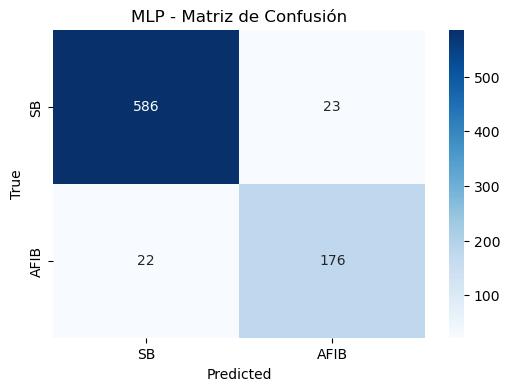

MLP - Reporte de Clasificación:
              precision    recall  f1-score   support

          SB       0.96      0.96      0.96       609
        AFIB       0.88      0.89      0.89       198

    accuracy                           0.94       807
   macro avg       0.92      0.93      0.92       807
weighted avg       0.94      0.94      0.94       807



In [11]:
def build_mlp(input_shape):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria
    
    # Compilar el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

# Crear y entrenar el modelo MLP
mlp_model = build_mlp(X_train.shape[1])

# Entrenar el modelo
mlp_history = mlp_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluar el modelo en los datos de prueba
mlp_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f'MLP Accuracy: {mlp_accuracy[1]:.4f}\n')

mlp_y_pred_prob = mlp_model.predict(X_test)
evaluate_model(y_test, mlp_y_pred_prob, "MLP")

# Modelo 2 (Segunda configuración)

Epoch 1/30


C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7686 - loss: 2.4952 - val_accuracy: 0.8872 - val_loss: 0.4366
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8717 - loss: 0.4845 - val_accuracy: 0.8178 - val_loss: 0.6417
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8822 - loss: 0.3798 - val_accuracy: 0.8922 - val_loss: 0.4049
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8611 - loss: 0.5689 - val_accuracy: 0.8897 - val_loss: 0.3021
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8905 - loss: 0.3503 - val_accuracy: 0.8860 - val_loss: 0.2846
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8753 - loss: 0.4819 - val_accuracy: 0.8761 - val_loss: 0.3441
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.2615 - val_accuracy: 0.9108 - val_loss: 0.2210
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8874 - loss: 0.3796 - val_accuracy: 0.8947 - val_

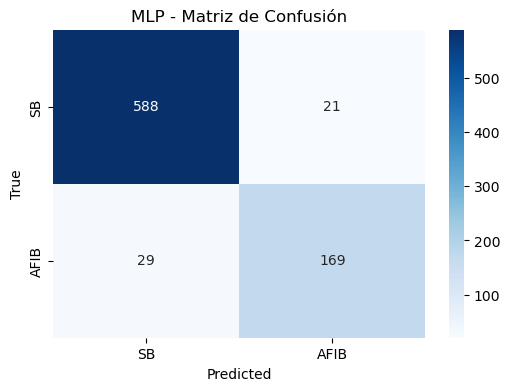

MLP - Reporte de Clasificación:
              precision    recall  f1-score   support

          SB       0.95      0.97      0.96       609
        AFIB       0.89      0.85      0.87       198

    accuracy                           0.94       807
   macro avg       0.92      0.91      0.92       807
weighted avg       0.94      0.94      0.94       807



In [12]:
def build_mlp1(input_shape):
    mlp_model_1 = Sequential()
    mlp_model_1.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))  # Capa de entrada con 128 neuronas
    mlp_model_1.add(Dense(64, activation='relu'))  # Capa oculta con 64 neuronas
    mlp_model_1.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas
    mlp_model_1.add(Dense(1, activation='sigmoid'))  # Capa de salida

    # Compilar el modelo
    mlp_model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return mlp_model_1

# Crear y entrenar el modelo MLP
mlp_model1 = build_mlp1(X_train.shape[1])

# Entrenar el modelo
mlp_history1 = mlp_model1.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluar el modelo en los datos de prueba
mlp_accuracy1 = mlp_model1.evaluate(X_test, y_test, verbose=0)
print(f'MLP Accuracy: {mlp_accuracy1[1]:.4f}\n')

mlp_y_pred_prob1 = mlp_model1.predict(X_test)
evaluate_model(y_test, mlp_y_pred_prob1, "MLP")

# Modelo 3 (Tercera configuración)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6943 - loss: 19.9793 - val_accuracy: 0.8761 - val_loss: 0.3358
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.3748 - val_accuracy: 0.8649 - val_loss: 0.2987
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3065 - val_accuracy: 0.8302 - val_loss: 0.3356
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8755 - loss: 0.2895 - val_accuracy: 0.8848 - val_loss: 0.2718
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8837 - loss: 0.2905 - val_accuracy: 0.8947 - val_loss: 0.2878
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8919 - loss: 0.2606 - val_accuracy: 0.8662 - val_loss: 0.2625
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8587 - loss: 0.2787 - val_accuracy: 0.8922 - val_loss: 0.2579
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - loss: 0.3012 - val_accuracy: 0

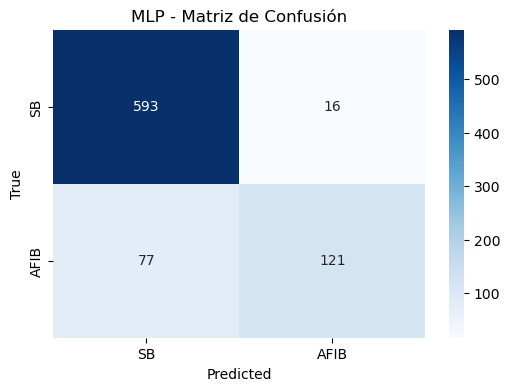

MLP - Reporte de Clasificación:
              precision    recall  f1-score   support

          SB       0.89      0.97      0.93       609
        AFIB       0.88      0.61      0.72       198

    accuracy                           0.88       807
   macro avg       0.88      0.79      0.82       807
weighted avg       0.88      0.88      0.88       807



In [15]:
def build_mlp2(input_shape):
    mlp_model_2 = Sequential()
    mlp_model_2.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))  # Capa de entrada con 256 neuronas
    mlp_model_2.add(Dense(128, activation='relu'))  # Capa oculta con 128 neuronas
    mlp_model_2.add(Dense(64, activation='relu'))  # Capa oculta con 64 neuronas
    mlp_model_2.add(Dense(32, activation='relu'))  # Capa oculta con 32 neuronas
    mlp_model_2.add(Dense(1, activation='sigmoid'))  # Capa de salida

    # Compilar el modelo con optimizador SGD
    mlp_model_2.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    
    return mlp_model_2

# Crear y entrenar el modelo MLP
mlp_model2 = build_mlp2(X_train.shape[1])

# Entrenar el modelo
mlp_history2 = mlp_model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluar el modelo en los datos de prueba
mlp_accuracy2 = mlp_model2.evaluate(X_test, y_test, verbose=0)
print(f'MLP Accuracy: {mlp_accuracy2[1]:.4f}\n')

mlp_y_pred_prob2 = mlp_model2.predict(X_test)
evaluate_model(y_test, mlp_y_pred_prob2, "MLP")

# Adicionalmente se evaluaron otras redes neuronales para evaluar su desempeño y compararlo con los modelos obtenidos previamente

# CNN (Convolutional Neural Network)

In [11]:
def build_cnn(input_shape):
    model = Sequential()

    # Ajustar la forma de la entrada para CNN: (samples, features, 1)
    model.add(Reshape((input_shape[0], 1), input_shape=(input_shape[0],)))
    
    # Capa convolucional 1 (kernel_size=2 y padding='same')
    model.add(Conv1D(64, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(2, padding='same'))
    
    # Capa convolucional 2
    model.add(Conv1D(128, kernel_size=2, activation='relu', padding='same'))
    model.add(MaxPooling1D(2, padding='same'))
    
    # Aplanar
    model.add(Flatten())
    
    # Capa densa
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida
    
    # Compilar el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

# Convertir los DataFrames a NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Reformatear la entrada para que tenga la forma (samples, features, 1)
X_train_cnn = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_cnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

# Crear y entrenar el modelo CNN
cnn_model = build_cnn(X_train_cnn.shape[1:])  # Pasar la forma de las características sin incluir el número de muestras
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_cnn, y_test), verbose=1)

# Evaluar el modelo
cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f'CNN Accuracy: {cnn_accuracy[1]:.4f}')

Epoch 1/20


C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7857 - loss: 3.0664 - val_accuracy: 0.7546 - val_loss: 1.3855
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8298 - loss: 0.9039 - val_accuracy: 0.8377 - val_loss: 0.9133
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.5373 - val_accuracy: 0.8129 - val_loss: 0.4289
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8907 - loss: 0.2808 - val_accuracy: 0.7807 - val_loss: 0.7253
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8744 - loss: 0.4136 - val_accuracy: 0.9058 - val_loss: 0.2312
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8798 - loss: 0.3615 - val_accuracy: 0.7732 - val_loss: 0.8541
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8838 - loss: 0.3026 - val_accuracy: 0.8587 - val_loss: 0.3481
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8820 - loss: 0.3460 - val_accuracy: 0.9207 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== CNN ===


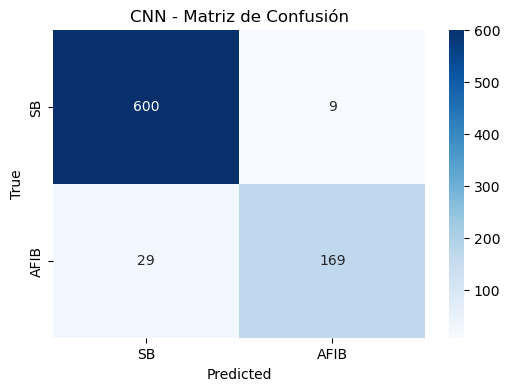

CNN - Reporte de Clasificación:
              precision    recall  f1-score   support

          SB       0.95      0.99      0.97       609
        AFIB       0.95      0.85      0.90       198

    accuracy                           0.95       807
   macro avg       0.95      0.92      0.93       807
weighted avg       0.95      0.95      0.95       807



In [12]:
# Obtener predicciones
cnn_y_pred_prob = cnn_model.predict(X_test_cnn)
evaluate_model(y_test, cnn_y_pred_prob, "CNN")

# RNN (Recurrent Neural Network)

In [13]:
def build_rnn(input_shape):
    model = Sequential()
    
    # LSTM con 64 unidades
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    
    # Capa densa
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida
    
    # Compilamos el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

# Convertir los DataFrames a arreglos de NumPy
X_train_np = X_train.values
X_test_np = X_test.values

# Ajustar X_train y X_test para que tengan la forma correcta para LSTM: (samples, timesteps, features)
X_train_rnn = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_rnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

# Crear y entrenar el modelo RNN (LSTM)
rnn_model = build_rnn((X_train_rnn.shape[1], 1))  # La entrada es (timesteps, features)

# Entrenar el modelo
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_rnn, y_test), verbose=1)

# Evaluar el modelo
rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f'RNN Accuracy: {rnn_accuracy[1]:.4f}')

Epoch 1/20


C:\Users\santi\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8252 - loss: 0.3595 - val_accuracy: 0.9108 - val_loss: 0.2146
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9134 - loss: 0.1974 - val_accuracy: 0.9207 - val_loss: 0.1876
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9224 - loss: 0.1847 - val_accuracy: 0.9257 - val_loss: 0.1729
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9297 - loss: 0.1682 - val_accuracy: 0.9294 - val_loss: 0.1594
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9194 - loss: 0.1589 - val_accuracy: 0.9393 - val_loss: 0.1216
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.1350 - val_accuracy: 0.9393 - val_loss: 0.1433
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9457 - loss: 0.1212 - val_accuracy: 0.9554 - val_loss: 0.0988
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9474 - loss: 0.1094 - val_accuracy: 0.9616 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
=== RNN ===


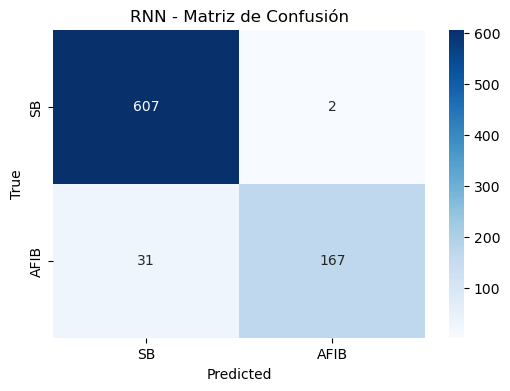

RNN - Reporte de Clasificación:
              precision    recall  f1-score   support

          SB       0.95      1.00      0.97       609
        AFIB       0.99      0.84      0.91       198

    accuracy                           0.96       807
   macro avg       0.97      0.92      0.94       807
weighted avg       0.96      0.96      0.96       807



In [14]:
# Obtener predicciones
rnn_y_pred_prob = rnn_model.predict(X_test_rnn)
evaluate_model(y_test, rnn_y_pred_prob, "RNN")

# K-Means

El algoritmo K-means es una técnica de machine learning no supervisada que se utiliza para agrupar datos en K clusters basados en su similitud. Este método comienza seleccionando aleatoriamente K centroides iniciales, que representan los centros de los clusters. Luego, asigna cada dato al cluster cuyo centroide esté más cerca, calculando la distancia (generalmente euclidiana). Posteriormente, actualiza los centroides como el promedio de las posiciones de los datos asignados a cada cluster. Este proceso de asignación y actualización se repite hasta que los centroides se estabilicen o se alcance un número máximo de iteraciones. K-means es particularmente útil para identificar patrones en datos no etiquetados, como segmentación de clientes o análisis de señales biomédicas. Sin embargo, su efectividad depende de la correcta selección de K y es sensible a valores atípicos y la inicialización de los centroides [6].

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Ajusted Rand Index (ARI): 0.7647
Homogeneity Score: 0.6771

Reporte de Clasificación:
              precision    recall  f1-score   support

          SB       0.99      0.93      0.96      3130
        AFIB       0.81      0.97      0.88       901

    accuracy                           0.94      4031
   macro avg       0.90      0.95      0.92      4031
weighted avg       0.95      0.94      0.94      4031



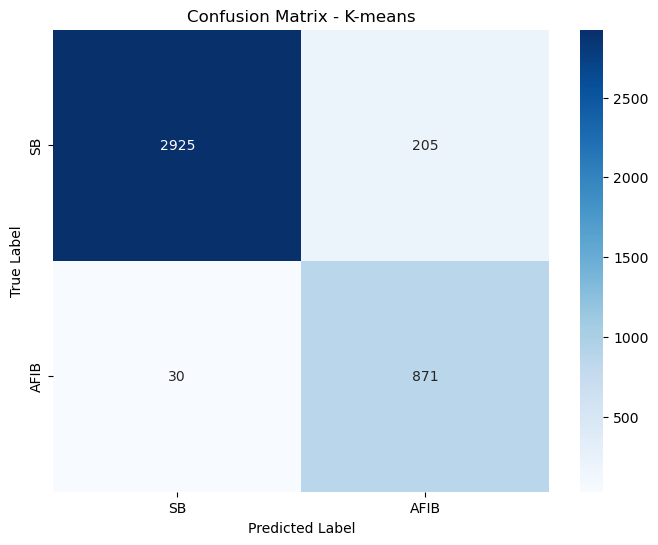

In [15]:
# 1. Escalar los datos (sin incluir la columna objetivo)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X es el conjunto de características sin la columna objetivo

# 2. Definir y entrenar el modelo K-means
n_clusters = 2  # Dos clústeres (AFIB y SB)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# 3. Obtener las etiquetas predichas
cluster_labels = kmeans.labels_

# 4. Evaluación de desempeño
# Mapear clústeres a etiquetas reales para mejorar la interpretación
# (esto puede variar dependiendo del orden de los clústeres)
mapped_labels = cluster_labels.copy()
if sum(mapped_labels == y) < sum(mapped_labels != y):
    mapped_labels = 1 - mapped_labels  # Reasigna los clústeres si es necesario

# Métricas
ari = adjusted_rand_score(y, mapped_labels)
homogeneity = homogeneity_score(y, mapped_labels)

print(f"Ajusted Rand Index (ARI): {ari:.4f}")
print(f"Homogeneity Score: {homogeneity:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y, mapped_labels, target_names=['SB', 'AFIB']))

# Matriz de confusión
conf_matrix = confusion_matrix(y, mapped_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['SB', 'AFIB'], yticklabels=['SB', 'AFIB'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - K-means")
plt.show()


# SVM (Support Vector Machine)

El algoritmo de Support Vector Machine (SVM) es una técnica supervisada utilizada para clasificación y regresión. Su objetivo principal es encontrar un hiperplano óptimo que separe los datos en diferentes clases, maximizando el margen entre ellos. Este margen es la distancia entre el hiperplano y los puntos más cercanos de cada clase, conocidos como vectores de soporte. Si los datos no son separables linealmente, SVM utiliza funciones kernel para transformar los datos a un espacio de características más alto, donde puedan ser separados. Esto lo hace especialmente eficaz para problemas no lineales y de alta dimensionalidad. SVM es robusto frente al overfitting, pero su rendimiento depende de la correcta selección del kernel y de los hiperparámetros. Se emplea ampliamente en problemas como clasificación de imágenes, detección de fraudes y análisis de señales biomédicas, donde se busca alta precisión en la diferenciación entre clases [7].

- El kernel RBF es una opción comúnmente utilizada en SVM debido a su capacidad para manejar problemas no lineales al proyectar los datos en un espacio de mayor dimensión. Este kernel es ideal cuando las relaciones entre las características no son lineales, lo que es frecuente en datos biomédicos como señales ECG. Al emplear RBF, el modelo puede captar patrones complejos necesarios para diferenciar condiciones cardíacas como AFIB y SB con mayor precisión.

- El parámetro C controla la compensación entre maximizar el margen del hiperplano y minimizar el error de clasificación en los datos de entrenamiento. Un valor de C=1.0 representa un balance moderado que permite al modelo ser flexible con pequeños errores de clasificación mientras evita el sobreajuste.

- El parámetro gamma controla la influencia de cada muestra en el modelo. Con gamma='scale', el valor se ajusta automáticamente como el inverso del número de características, garantizando que la influencia de cada dato sea proporcional al tamaño del conjunto de datos.

- El parámetro random state asegura la reproducibilidad de los resultados al fijar una semilla para los procesos aleatorios del algoritmo, como la inicialización de los vectores de soporte.

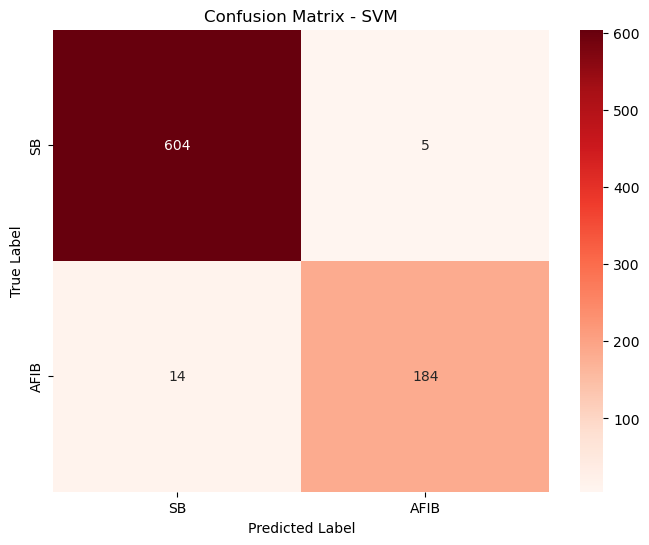

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       609
           1       0.97      0.93      0.95       198

    accuracy                           0.98       807
   macro avg       0.98      0.96      0.97       807
weighted avg       0.98      0.98      0.98       807



In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar el modelo con kernel RBF
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Entrenar el modelo
svm_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred = svm_model.predict(X_test_scaled)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=['SB', 'AFIB'], yticklabels=['SB', 'AFIB'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


# Consulta de equipos comerciales incorporados con algoritmos de ayuda diagnóstica a partir de señales EKG

**GE Healthcare MAC VU360:**
El GE Healthcare MAC VU360 se posiciona como un dispositivo líder en el análisis de señales ECG gracias a su integración de tecnología avanzada como la Marquette 12SL y el algoritmo Zero Phase Distortion (ZPD). La Marquette 12SL permite un análisis robusto de las 12 derivaciones estándar del ECG, lo que resulta esencial para identificar cambios precisos en segmentos ST y detectar arritmias. Esto tiene una relevancia directa en el análisis de datos de bioseñales, ya que un enfoque multiderivación permite detectar patrones en la actividad cardíaca que de otro modo podrían pasar desapercibidos. Desde una perspectiva técnica, el algoritmo ZPD optimiza el procesamiento de señales al eliminar ruido de baja frecuencia, garantizando que las características importantes como los complejos QRS o las ondas P sean analizadas con alta fidelidad. Por otro lado, el sistema Smart Auto-ECG emplea aprendizaje automático para clasificar ritmos cardíacos, lo que mejora la precisión diagnóstica al procesar bioseñales en tiempo real. Estas funcionalidades destacan cómo la combinación de algoritmos avanzados de procesamiento y aprendizaje automático permite interpretar con mayor exactitud patrones cardíacos complejos y proporciona un análisis optimizado que beneficia tanto a médicos como a pacientes [15].

**Philips PageWriter TC50:**
El Philips PageWriter TC50 es un electrocardiógrafo que combina precisión diagnóstica y eficiencia operativa mediante el algoritmo DXL de 12 derivaciones. Este algoritmo sobresale por su capacidad para detectar condiciones críticas como isquemias, arritmias ventriculares y supraventriculares, lo que lo convierte en una herramienta clave para el análisis de bioseñales complejas. La incorporación de herramientas de guía visual hace que este dispositivo sea fácil de usar, incluso en escenarios clínicos de alta demanda. El algoritmo DXL se basa en técnicas avanzadas como recortes alfa y análisis espectral, que proporcionan un procesamiento robusto de las señales eléctricas del corazón. Al analizar tendencias centrales y patrones estadísticos, este electrocardiógrafo logra identificar con precisión eventos cardíacos relevantes. Desde una perspectiva de análisis de datos, esta capacidad de evaluar múltiples derivaciones simultáneamente y correlacionar patrones en tiempo real es crucial para generar insights significativos y reducir el margen de error en diagnósticos [16].

**CardioVIT FT-1**
El CardioVIT FT-1 de SCHILLER combina portabilidad y precisión, lo que lo convierte en un dispositivo versátil para entornos clínicos. Su frecuencia de muestreo de 32,000 Hz asegura una resolución excepcional en la adquisición de señales ECG, incluso en condiciones ruidosas. Esto no solo mejora la calidad de las bioseñales procesadas, sino que también facilita la detección temprana de anomalías cardíacas en tiempo real, permitiendo generar reportes diagnósticos detallados para pacientes adultos y pediátricos. Desde el punto de vista técnico, algoritmos como el CCAA (Coronary Care Area Analysis) permiten localizar obstrucciones coronarias y analizar áreas afectadas mediante transformadas de Fourier y análisis espectral. Estos enfoques están directamente relacionados con el procesamiento avanzado de bioseñales, ya que brindan información cuantitativa que complementa la interpretación clínica. Además, el filtrado en tiempo real empleado en este dispositivo es crucial para minimizar el impacto de artefactos, asegurando que los datos analizados reflejen fielmente la actividad cardíaca del paciente [17].


Estos dispositivos demuestran cómo el avance en la tecnología médica está estrechamente ligado a las innovaciones en el análisis de datos fisiológicos. Los algoritmos avanzados y las capacidades de filtrado aseguran que las señales obtenidas sean claras, minimizando artefactos que podrían comprometer el análisis sumado a la capacidad de analizar datos inmediatamente después de su captura permite detectar patrones o eventos clínicos críticos, acelerando la toma de decisiones. La integración de técnicas espectrales, temporales y estadísticas en el análisis de bioseñales amplía la comprensión de los patrones fisiológicos, permitiendo diagnósticos más precisos y personalizados. Dispositivos como el CardioVIT FT-1 destacan por llevar el análisis avanzado a contextos fuera del hospital, democratizando el acceso a herramientas de diagnóstico avanzadas. 



# Análisis de resultados obtenidos de los modelos

Antes de entrenar los modelos, se procesaron los datos eliminando las filas con valores nulos para evitar problemas de inconsistencia en el análisis. Si bien otras técnicas, como la imputación de valores promedio o aleatorios, son válidas, se optó por esta medida para garantizar un conjunto de datos limpio. Además, se eliminaron columnas irrelevantes, como la del registro, lo que evitó que estas influenciaran indebidamente los resultados del modelo. Los datos fueron escalados con StandardScaler, lo cual asegura que todas las características tengan la misma escala y evita que los modelos sean sesgados por valores con mayor rango numérico.

Es importante destacar que, dado que los datos se organizaron inicialmente de forma que la primera mitad correspondiera a sujetos con AFIB y la segunda mitad a sujetos con SB, esto pudo haber ocasionado una distribución no proporcional entre los conjuntos de entrenamiento y prueba. Sin embargo, los modelos lograron mantener altos niveles de precisión y desempeño, lo que demuestra su robustez frente a esta posible fuente de sesgo.También es necesario mencionar que para los modelos con redes neuronales, uno de los argumentos fundamentales para las funciones son las épocas (epochs) las cuales indica el número de veces que el modelo recorrerá todo el conjunto de datos de entrenamiento durante el proceso de aprendizaje [9]. Dicho argumento fue modificado variando su valor hasta encontrar un valor óptimo para la época de modo que el porcentaje de accuracy sea el mayor posible.

### MLP (Multilayer Perceptron)
**Modelo 1**
El primer modelo logró un accuracy de 94.42%, destacándose por un balance entre precisión y recall para ambas clases. Sin embargo, hay una leve desventaja en la clasificación de AFIB, evidenciada por los 22 falsos negativos y 23 falsos positivos en la matriz de confusión. Esto se traduce en un recall de 89% para AFIB, lo que implica que el modelo pierde algunos casos reales de esta enfermedad. Esta tendencia podría estar relacionada con la menor proporción de datos AFIB en el conjunto, lo que indica que el modelo no generaliza de manera óptima para clases minoritarias. El f1-score ponderado de 94% refleja que, a pesar de las limitaciones mencionadas, el MLP mantiene un desempeño sólido. Desde el punto de vista clínico, su desempeño es aceptable, pero las fallas en la detección de AFIB podrían implicar diagnósticos perdidos, lo que es crítico dado que AFIB está asociada con un mayor riesgo de complicaciones como accidentes cerebrovasculares.

**Modelo 2**
El segundo modelo alcanzó una precisión de 0.9380. Si bien esta precisión es ligeramente inferior a la del Modelo 1, los resultados siguen siendo sólidos. La matriz de confusión muestra un total de 588 predicciones correctas para SB y 169 para AFIB, con un mayor número de falsos negativos en la clase AFIB (29 casos). Esto se refleja en un f1-score de 0.96 para SB y 0.87 para AFIB. Aunque la precisión general es alta, este modelo presenta un desbalance leve en su desempeño entre ambas clases.

**Modelo 3**
El tercer modelo mostró un rendimiento más bajo con una precisión de 0.8848. Este descenso puede atribuirse al diseño del modelo, que tiene menor capacidad para manejar la complejidad del problema. La matriz de confusión revela un mayor número de falsos negativos para AFIB (77), lo que se traduce en un f1-score de 0.72 para esta clase. Por otro lado, el modelo sigue desempeñándose bien para SB, con un f1-score de 0.93. Este comportamiento evidencia una limitación en la capacidad del modelo para generalizar los patrones asociados a sujetos con AFIB, probablemente debido a una arquitectura menos adecuada o insuficiente regularización.

### CNN (Convolutional Neural Network)
La CNN alcanzó un accuracy de 95%, superando al mejor MLP en un 1% aproximadamente. Este modelo mostró una notable capacidad para reducir los falsos positivos en SB (9 en comparación con 28 en MLP), lo que refleja su fortaleza en detectar correctamente la clase mayoritaria. Sin embargo, su recall para AFIB se redujo al 85%, indicando que sigue cometiendo errores al identificar esta enfermedad. Esto podría deberse a que la arquitectura convolucional, aunque excelente para capturar patrones espaciales, podría estar limitada en su capacidad para abordar características temporales complejas que son críticas en la dinámica de AFIB. El f1-score ponderado de 95% destaca que la CNN maneja bien la variabilidad general en los datos. Clínicamente, su desempeño es prometedor, pero los casos de AFIB mal clasificados aún representan un riesgo, ya que AFIB requiere una detección temprana para evitar complicaciones. Desde un punto de vista técnico, ajustar la arquitectura para integrar más sensibilidad temporal podría mejorar los resultados.

### RNN (Recurrent Neural Network)
El RNN presentó el mejor desempeño entre las redes neuronales, con un accuracy de 96%. Su matriz de confusión destaca por el bajo número de falsos positivos para SB (2) y su recall perfecto del 100% para SB, lo que indica que identifica todos los casos de esta clase correctamente. Aunque su precisión para AFIB es elevada (99%), su recall es de 84%, sugiriendo que el modelo aún pierde algunos casos reales de AFIB. Este comportamiento puede deberse a que los datos de AFIB contienen una mayor variabilidad temporal, lo que podría ser difícil de aprender completamente incluso para una RNN. El f1-score ponderado de 96% refuerza su capacidad para manejar datos secuenciales, siendo este modelo especialmente efectivo para representar patrones dinámicos en señales ECG. Desde un punto de vista clínico, su alta sensibilidad para SB lo hace ideal para evitar falsos positivos en esta condición. Sin embargo, los falsos negativos para AFIB siguen siendo una preocupación, lo que sugiere la necesidad de combinar este modelo con otro enfoque o mejorar su capacidad de generalización.

### K-Means
El K-Means, aunque es un modelo no supervisado, obtuvo un sorprendente accuracy de 94%. Este resultado es notable dado que el modelo no utiliza etiquetas durante el entrenamiento. Sin embargo, presenta un mayor número de falsos positivos para SB (205), lo que se refleja en un recall de 93% para esta clase. En comparación, su precision para AFIB es más baja (81%), indicando una tendencia a clasificar incorrectamente algunos casos de SB como AFIB. El desempeño del K-Means puede ser útil en contextos exploratorios o como un punto de partida para el análisis. Sin embargo, sus limitaciones hacen que no sea ideal para aplicaciones clínicas críticas, donde la precisión en el diagnóstico es esencial. Estos resultados reflejan la dificultad inherente de separar estas clases con un modelo no supervisado, especialmente cuando las características de las señales presentan cierta superposición.

### SVM (Support Vector Machine)
El SVM obtuvo el mejor desempeño global, con un accuracy de 98% y un equilibrio sobresaliente entre las métricas de precisión y recall para ambas clases. La matriz de confusión muestra solo 5 falsos positivos para SB y 14 falsos negativos para AFIB, lo que se traduce en un f1-score promedio ponderado de 98%. Esto demuestra que el modelo tiene una excelente capacidad para distinguir entre las dos clases. El éxito del SVM puede atribuirse al uso del kernel RBF, que permite separar eficazmente las clases en un espacio de características de alta dimensionalidad. Desde el punto de vista clínico, este modelo es ideal para aplicaciones donde la precisión es crucial, ya que minimiza tanto los diagnósticos incorrectos como los casos perdidos. La elección de parámetros como C=1.0 y gamma='scale' también favorece un balance adecuado entre el ajuste del modelo y su capacidad de generalización.

Todos los modelos mostraron un rendimiento competitivo, con la SVM destacándose como el modelo más preciso y balanceado para este conjunto de datos. Mientras que el RNN fue el mejor entre las redes neuronales, el MLP y la CNN también demostraron ser alternativas viables. Por otro lado, el K-Means, aunque menos preciso, resaltó como una opción interesante en análisis exploratorios o sin etiquetas. La mayoría de los modelos presentan un desempeño sólido, con accuracies superiores al 94%, lo que refleja la calidad de las características extraídas de las señales ECG. Sin embargo, los falsos negativos en AFIB son una preocupación constante, dado el impacto clínico de no detectar esta enfermedad.



# Conclusiones

Las características seleccionadas del análisis de las señales ECG, como Heart Rate Mean, HRV_SDNN, RR Interval Mean, R Amplitude Mean, HRV_RMSSD, y P Wave Duration Mean, demostraron ser relevantes para diferenciar entre Bradicardia Sinusal (SB) y Fibrilación Auricular (AFIB). Estas características capturan aspectos clave de la dinámica cardíaca, como la variabilidad en los intervalos R-R y la amplitud de los picos R, que están directamente influenciados por la fisiopatología de las enfermedades. La elección y análisis detallado de estas métricas permitieron construir modelos predictivos altamente eficaces.

Los modelos de aprendizaje supervisado y no supervisado empleados en este análisis presentaron resultados sólidos en la clasificación de SB y AFIB, con accuracies superiores al 94%. SVM destacó como el modelo más eficaz, alcanzando un accuracy del 98% y un excelente equilibrio entre precisión y recall. Esto lo posiciona como el modelo más confiable para aplicaciones clínicas debido a su capacidad de minimizar tanto los falsos positivos como los falsos negativos. RNN logró capturar con precisión la dinámica temporal de las señales ECG, obteniendo un accuracy del 96%. Si bien mostró un recall perfecto para SB, aún enfrenta desafíos en la detección completa de AFIB. CNN y MLP tuvieron un desempeño competitivo, con accuracies del 95% y 94.4%, respectivamente, destacándose en la identificación de patrones espaciales y generales de las señales ECG. Sin embargo, ambos modelos presentaron una ligera tendencia a subestimar los casos de AFIB. K-Means, como modelo no supervisado, demostró ser útil para análisis exploratorios al alcanzar un accuracy del 94%. Sin embargo, sus limitaciones en la clasificación de señales con variabilidad hacen que no sea ideal para aplicaciones diagnósticas críticas.

El desempeño de los modelos MLP refleja su capacidad para manejar un problema complejo de clasificación, incluso con características extraídas previamente y datos distribuidos de forma asimétrica. Sin embargo, también evidencia la importancia de una adecuada selección de hiperparámetros y arquitecturas. Los resultados del Modelo 1 y Modelo 2 destacan la importancia de una configuración bien equilibrada, mientras que el Modelo 3 muestra que decisiones como la reducción excesiva de complejidad (uso del optimizador SGD) pueden afectar significativamente el rendimiento.

La evaluación por clase indica que todos los modelos tienden a presentar un mejor rendimiento en la detección de sujetos con SB. Esto podría estar relacionado con la mayor estabilidad y uniformidad de las señales de esta clase en comparación con las de AFIB, que presentan mayor variabilidad. No obstante, los falsos negativos en AFIB son una preocupación recurrente, dado el riesgo asociado con esta condición. Modelos como el SVM ofrecen una solución robusta, pero es esencial considerar la integración de enfoques híbridos o ajustes adicionales para garantizar la sensibilidad en estas detecciones.

El análisis del dataframe y de las distribuciones de las características confirma que las señales procesadas están en condiciones óptimas para ser analizadas. Además, se identificó que las señales seleccionadas del Proyecto 2 proporcionaron mayor consistencia en las métricas extraídas, mientras que las señales del Proyecto 3 presentaron sesgos y variabilidad, justificando su exclusión del análisis principal.

Aunque los modelos lograron una alta precisión global, se observan limitaciones en la capacidad para detectar todos los casos de AFIB, principalmente debido a la variabilidad intrínseca de las señales y el desequilibrio en las clases. Futuros trabajos deberían explorar técnicas de balanceo de datos, optimización de hiperparámetros y arquitecturas avanzadas que combinen las fortalezas de los modelos probados. Además, la incorporación de características adicionales extraídas de la libreria NeuroKit o incluso derivadas de otros dominios, como transformadas de tiempo-frecuencia, podría mejorar la discriminación entre las clases.

# Referencias

[0]. Base de datos obtenida de: https://figshare.com/collections/ChapmanECG/4560497/1

[1]. L. A. Leon-Pacheco, J. P. Ávila-Vinueza y X. R. Yambay-Bautista, “Bradicardia sinusal: Caso clínico”, MQRInvestigar, vol. 8, n.º 1, pp. 1976–1995, febrero de 2024. [En línea]. Disponible: https://doi.org/10.56048/mqr20225.8.1.2024.1976-1995

[2]. “Fibrilación auricular - Fibrilación auricular - Manual MSD versión para profesionales”. Manual MSD versión para profesionales. [En línea]. Disponible: https://www.msdmanuals.com/es/professional/trastornos-cardiovasculares/arritmias-cardíacas-específicas/fibrilación-auricular

[3]. "Perceptrones multicapa en el aprendizaje automático: Guía completa". Datacamp. [En línea]. Disponible: https://www.datacamp.com/es/tutorial/multilayer-perceptrons-in-machine-learning

[4]. "Tutorial de Redes Neuronales Convolucionales (CNN) con TensorFlow". Datacamp. [En línea]. Disponible: https://www.datacamp.com/es/tutorial/cnn-tensorflow-python

[5]. "Tutorial de redes neuronales recurrentes (RNN)". Datacamp. [En línea]. Disponible:  https://www.datacamp.com/es/tutorial/tutorial-for-recurrent-neural-network

[6]. “K-Means con python paso a paso | aprende machine learning”. Aprende Machine Learning en Español. [En línea]. Disponible: https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

[7]. "Tutorial sobre máquinas de vectores de soporte con Scikit-learn". Datacamp. [En línea]. Disponible: https://www.datacamp.com/es/tutorial/svm-classification-scikit-learn-python

[8]. “Optimal multi-stage arrhythmia classification approach - scientific reports”. Nature. [En línea]. Disponible: https://www.nature.com/articles/s41598-020-59821-7

[9]. "Epoch in Neural Networks". Baeldung. [En línea]. Disponible: https://www.baeldung.com/cs/epoch-neural-networks

[10]. “Adam | interactive chaos”. Home page | Interactive Chaos. [En línea]. Disponible: https://interactivechaos.com/es/manual/tutorial-de-machine-learning/adam

[11]. S. Lozada. “Mini-Curso de deep learning: Optimizadores”. Medium. [En línea]. Disponible: https://medium.com/latinxinai/optimizadores-5123992d344c#:~:text=SGD%20(Stochastic%20gradient%20descent):,una%20estimación%20estocástica%20de%20este.

[12]. N. Dugarte J, A. Alvarez, E. Dugarte y G. Álvarez, “Técnicas de procesamiento de la señal ECGAR aplicadas en el prototipo DIGICARDIAC”, Rev. Del Inst. Nac. Hig. “Rafael Rangel”, Vol 46, pp. 1–2, 2015.

[13]. “Sistema para la adquisición de la señal electrocardiográfica de alta resolución 3 n”. SciELO - Scientific Electronic Library Online. [En línea]. Disponible: https://ve.scielo.org/scielo.php?script=sci_arttext&amp;pid=S1316-48212011000400004

[14]. Makowski, D. (2021). Neurophysiological Data Analysis with NeuroKit2. NeuroKit. https://neuropsychology.github.io/NeuroKit/

[15]. Premier Source of Medical Equipment - CardiacDirect. [En línea]. Disponible: https://www.cardiacdirect.com/wp-content/uploads/2023/07/GE-MAC-VU360_Brochure.pdf

[16]. “PageWriter TC50 | Philips”. Philips. [En línea]. Disponible: https://www.philips.com.au/healthcare/product/HC860310/pagewriter-tc50-cardiograph

[17]. “SCHILLER | CARDIOVIT FT-1”. SCHILLER: Swiss-designed innovative medical technology. [En línea]. Disponible: https://www.schiller.ch/es-es/productos/cardiovit-ft-1-p186